Data Generation



We'll generate a synthetic dataset that simulates the complex process

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set Random Seed
To ensure reproducibility.

In [4]:
np.random.seed(42)

Generate Input Variables
Let's assume we have 10 input variables.

In [6]:
n_samples = 1000
n_features = 10

# Generate random input features between 0 and 10
X = np.random.uniform(0, 10, size=(n_samples, n_features))


Assign Coefficients
Randomly assign coefficients 𝛽 for each term.

In [11]:
beta_linear = np.random.uniform(-5, 5, size=n_features)

In [12]:
# Coefficients for interaction terms (n_features choose 2)
n_interactions = int(n_features * (n_features - 1) / 2)
beta_interaction = np.random.uniform(-1, 1, size=n_interactions)

In [13]:
# Linear combination of inputs
linear_terms = np.dot(X, beta_linear)


In [14]:
# Initialize interaction terms array
interaction_terms = np.zeros(n_samples)

# Index to keep track of interaction coefficients
idx = 0

# Loop over all unique pairs of features
for i in range(n_features):
    for j in range(i + 1, n_features):
        # Add interaction term
        interaction_terms += beta_interaction[idx] * X[:, i] * X[:, j]
        idx += 1

In [15]:
epsilon = np.random.normal(0, 1, n_samples)

In [16]:
# Total output
y = beta_linear[0] + linear_terms + interaction_terms + epsilon

In [17]:
# Feature names
columns = [f'x{i+1}' for i in range(n_features)]

# Combine features and target into a DataFrame
data = pd.DataFrame(X, columns=columns)
data['y'] = y

In [20]:
print(data.head(5))


         x1        x2        x3        x4        x5        x6        x7  \
0  3.745401  9.507143  7.319939  5.986585  1.560186  1.559945  0.580836   
1  0.205845  9.699099  8.324426  2.123391  1.818250  1.834045  3.042422   
2  6.118529  1.394939  2.921446  3.663618  4.560700  7.851760  1.996738   
3  6.075449  1.705241  0.650516  9.488855  9.656320  8.083973  3.046138   
4  1.220382  4.951769  0.343885  9.093204  2.587800  6.625223  3.117111   

         x8        x9       x10           y  
0  8.661761  6.011150  7.080726  178.654324  
1  5.247564  4.319450  2.912291   85.918166  
2  5.142344  5.924146  0.464504   76.613757  
3  0.976721  6.842330  4.401525  -94.338920  
4  5.200680  5.467103  1.848545  -38.892191  


3. Data Preprocessing
Handling Missing Values
Our synthetic data has no missing values, but in real scenarios, you'd handle them here.

Feature Scaling
Neural networks converge faster with scaled features.

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform features
X_scaled = scaler.fit_transform(data.drop('y', axis=1))

# Update DataFrame
data_scaled = pd.DataFrame(X_scaled, columns=columns)
data_scaled['y'] = data['y']


Check Scaled Data

In [23]:
print(data_scaled.head())

         x1        x2        x3        x4        x5        x6        x7  \
0 -0.363066  1.547478  0.821234  0.361551 -1.177298 -1.196034 -1.532007   
1 -1.603520  1.612962  1.167403 -1.011189 -1.087152 -1.101643 -0.670775   
2  0.468607 -1.219938 -0.694585 -0.463887 -0.129166  0.970644 -1.036627   
3  0.453509 -1.114080 -1.477198  1.606041  1.650825  1.050610 -0.669475   
4 -1.247970 -0.006553 -1.582870  1.465451 -0.818335  0.548268 -0.644644   

         x8        x9       x10           y  
0  1.302662  0.337660  0.761895  178.654324  
1  0.121575 -0.252714 -0.690874   85.918166  
2  0.085176  0.307297 -1.543968   76.613757  
3 -1.355854  0.627727 -0.171851  -94.338920  
4  0.105356  0.147797 -1.061607  -38.892191  


4. Feature Selection
Correlation Analysis

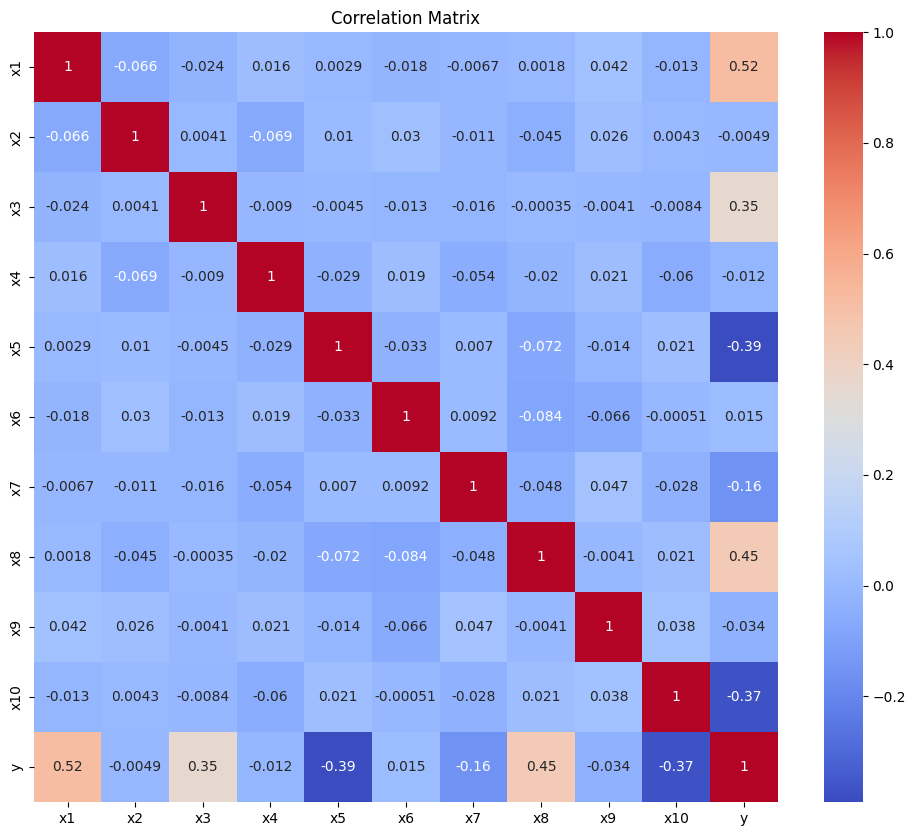

In [24]:
# Compute correlation matrix
corr_matrix = data_scaled.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Explanation:

Purpose: Identify highly correlated features.
Action: We can decide to remove features with high multicollinearity.
Select Features
For simplicity, we'll proceed with all features, but in practice, you might select a subset.

7. Feature Engineering
Creating Interaction Features
Using DOE principles to include interaction terms.

In [25]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree=2 includes interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Fit and transform features
X_poly = poly.fit_transform(data_scaled.drop('y', axis=1))

# Get feature names
feature_names = poly.get_feature_names_out(columns)


Explanation
PolynomialFeatures:
degree=2: Includes all combinations of features up to degree 2.
interaction_only=True: Excludes squared terms, focusing on interactions.

Update DataFrame with Interaction Features


In [26]:
# Create DataFrame with interaction features
data_poly = pd.DataFrame(X_poly, columns=feature_names)
data_poly['y'] = data_scaled['y']


5. Neural Network Model Implementation
Libraries

Split Data into Training and Testing Sets

In [29]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = data_poly.drop('y', axis=1).values
y = data_poly['y'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Define the Neural Network Architecture


In [31]:
# Input dimension after adding interaction terms
input_dim = X_train.shape[1]

# Initialize the model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=input_dim, activation='relu'))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7168      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 73217 (286.00 KB)
Trainable params: 73217 (286.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)


Explanation:

Optimizer: Adam optimizer adapts learning rates during training.
Loss Function: Mean Squared Error for regression tasks.
Metrics: Mean Absolute Error to evaluate model performance.

6. Model Training
Set Up Early Stopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


Train the Model


In [35]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


20/20 [==============================] - 1s 9ms/step - loss: 8648.7988 - mean_absolute_error: 73.9305 - val_loss: 6188.2852 - val_mean_absolute_error: 59.7385
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 8036.2563 - mean_absolute_error: 71.0626 - val_loss: 5332.3345 - val_mean_absolute_error: 55.5473
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 4886.9434 - mean_absolute_error: 53.6557 - val_loss: 2312.6646 - val_mean_absolute_error: 36.2888
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 1039.7753 - mean_absolute_error: 24.2208 - val_loss: 453.5901 - val_mean_absolute_error: 16.8014
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 292.7521 - mean_absolute_error: 13.1802 - val_loss: 213.3192 - val_mean_absolute_error: 11.3393
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 181.5477 - mean_absolute_error: 10.2701 - val_loss: 151.1905 - val_mean_a

Plot Training History


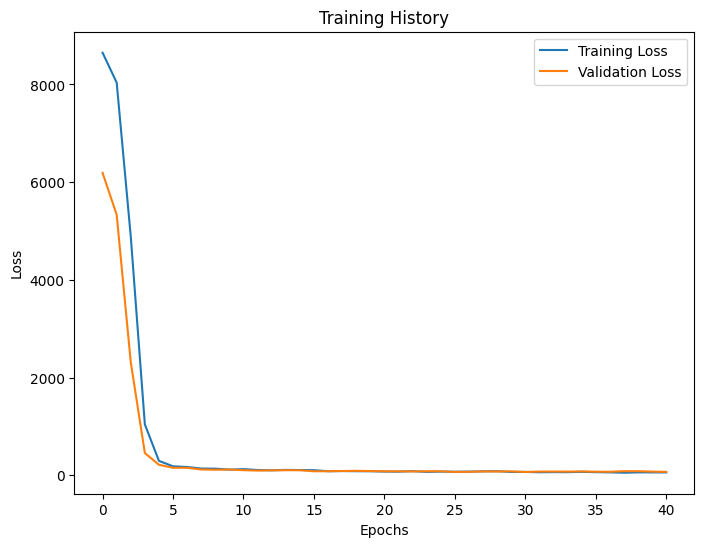

In [36]:
# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()


Explanation:

Early Stopping: Prevents overfitting by stopping training when validation loss doesn't improve.
Batch Size: Set to 32 for efficient computation.
Validation Split: 20% of training data used for validation

7. Model Evaluation
Evaluate on Test Data

In [37]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test MSE: 73.7218
Test MAE: 6.5903


Predict on Test Data


In [38]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 1ms/step


In [39]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')


Mean Squared Error: 73.7218
R^2 Score: 0.9906


Plot Predicted vs Actual Values


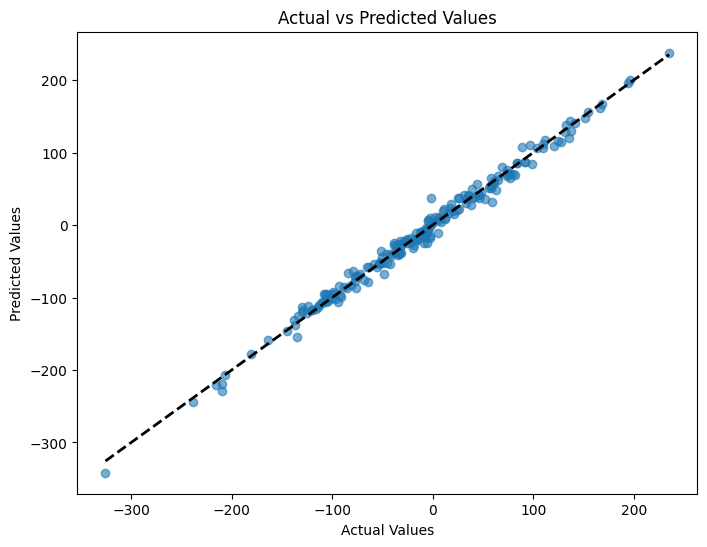

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

Explanation:

R^2 Score: Indicates how well the model explains the variability of the target variable.
Mean Squared Error: Average squared difference between predicted and actual values.


8. Optimization and Conclusion
Hyperparameter Tuning
To improve the model, consider tuning hyperparameters:

Number of Layers and Neurons: Experiment with different architectures.
Learning Rate: Adjust optimizer learning rate.
Batch Size and Epochs: Modify based on convergence behavior.
Activation Functions: Try different activation functions like tanh or leaky ReLU.
Cross-Validation
Implement k-fold cross-validation to ensure model robustness.

In [69]:
from sklearn.model_selection import KFold

# Define KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for results
mse_scores = []

for train_index, val_index in kfold.split(X):
    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Build model (you might want to define a function for this)
    model_fold = Sequential()
    model_fold.add(Dense(64, input_dim=n_features, activation='relu'))
    model_fold.add(Dense(128, activation='relu'))
    model_fold.add(Dropout(0.2))
    model_fold.add(Dense(64, activation='relu'))
    model_fold.add(Dense(1, activation='linear'))
    model_fold.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    model_fold.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate model
    y_val_pred = model_fold.predict(X_val_fold)
    mse_fold = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse_fold)

print(f'Cross-Validated MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}')


7/7 [==============================] - 0s 1000us/step
Cross-Validated MSE: 487.9427 ± 56.5823


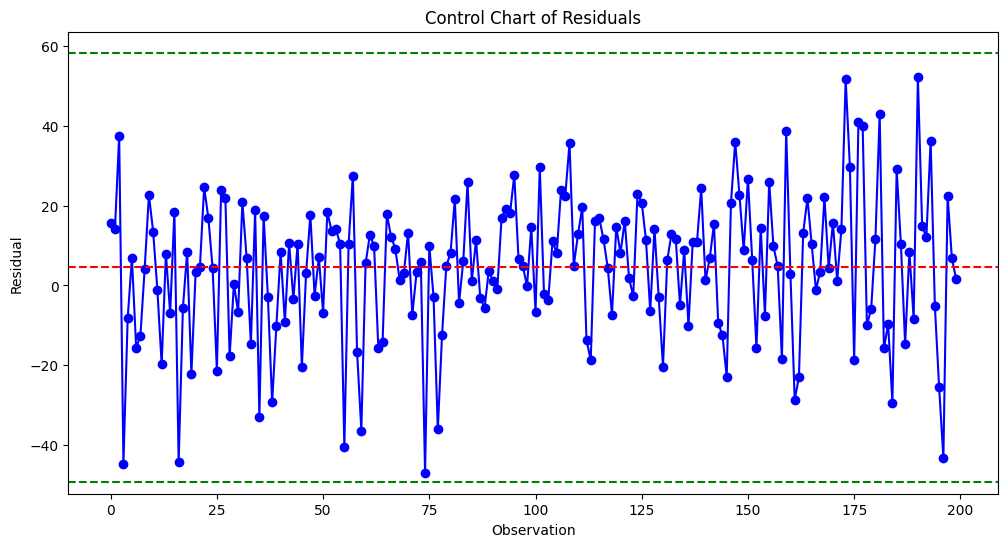

In [70]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Plot control chart
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b')
plt.axhline(y=np.mean(residuals), color='r', linestyle='--')
plt.axhline(y=np.mean(residuals) + 3*np.std(residuals), color='g', linestyle='--')
plt.axhline(y=np.mean(residuals) - 3*np.std(residuals), color='g', linestyle='--')
plt.title('Control Chart of Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()


Explanation:

Control Limits: Set at ±3 standard deviations from the mean residual.
Purpose: Detect any out-of-control signals indicating model issues.
Conclusion
Model Performance: Our neural network captures the complex relationships in the data.
Optimization: Further tuning and feature engineering can enhance performance.
SPC Application: Helps in monitoring and maintaining model reliability over time.

Next Steps
Feature Engineering: Incorporate more interaction terms and nonlinear transformations.
Advanced Techniques: Use models like XGBoost or Random Forests for comparison.
Deployment: Implement the model in a production environment with continuous monitoring.


11. Applying Statistical Process Control
Residual Analysis

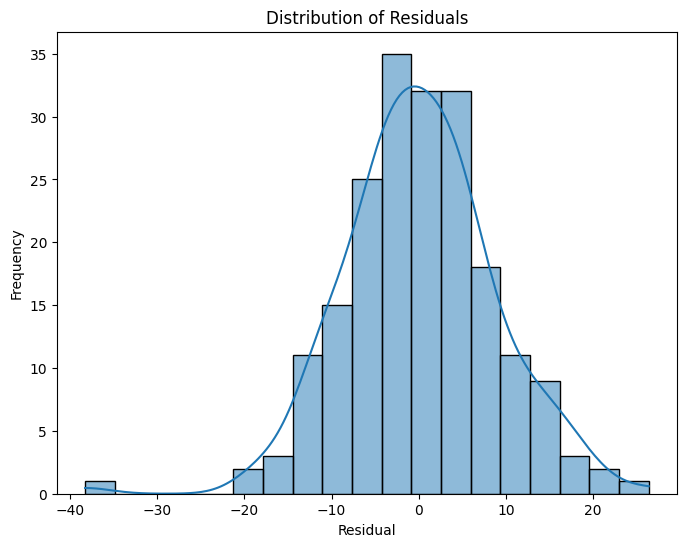

In [41]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


Control Chart of Residuals


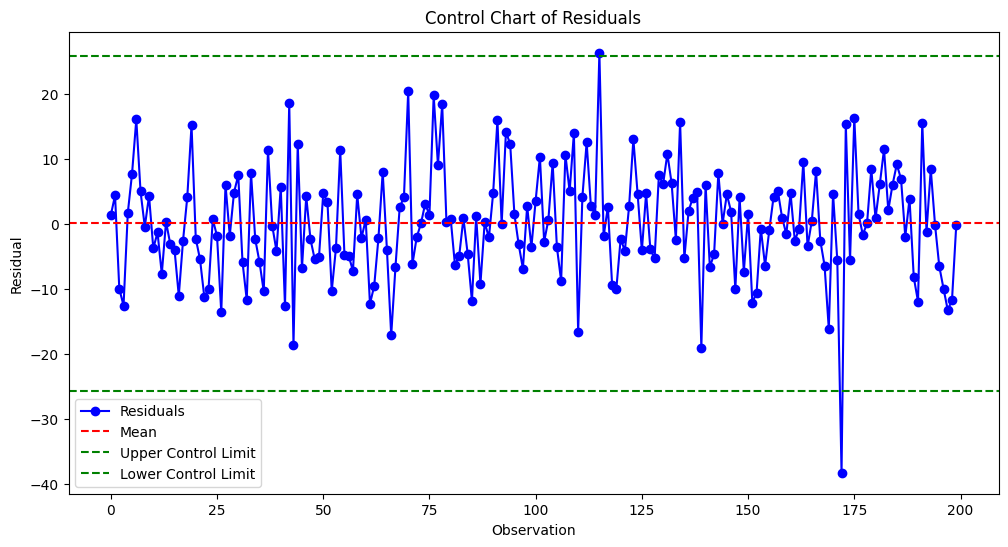

In [42]:
# Control chart parameters
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
upper_control_limit = mean_residual + 3 * std_residual
lower_control_limit = mean_residual - 3 * std_residual

# Plot control chart
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b', label='Residuals')
plt.axhline(y=mean_residual, color='r', linestyle='--', label='Mean')
plt.axhline(y=upper_control_limit, color='g', linestyle='--', label='Upper Control Limit')
plt.axhline(y=lower_control_limit, color='g', linestyle='--', label='Lower Control Limit')
plt.title('Control Chart of Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.legend()
plt.show()


Explanation
Purpose: Identify any out-of-control points indicating model issues.
Control Limits: Set at ±3 standard deviations from the mean residual.

Process Capability Analysis

In [43]:
# Process capability indices
process_std = np.std(y_test)
spec_limits = [np.min(y_test), np.max(y_test)]  # Assuming specifications are the min and max of y_test
process_mean = np.mean(y_test)

# Calculate Cp and Cpk
Cp = (spec_limits[1] - spec_limits[0]) / (6 * process_std)
Cpk = min((spec_limits[1] - process_mean), (process_mean - spec_limits[0])) / (3 * process_std)

print(f'Process Capability Cp: {Cp:.4f}')
print(f'Process Capability Cpk: {Cpk:.4f}')


Process Capability Cp: 1.0575
Process Capability Cpk: 0.9323


Explanation
Cp and Cpk: Indices to assess the process capability in meeting specifications.
Interpretation:
Cp > 1: Process has the potential to meet specifications.
Cpk > 1: Process is centered between the specification limits.

12. Quality Management Considerations
Plan-Do-Check-Act (PDCA) Cycle
Plan: Defined the problem, objectives, and planned data generation and modeling approach.
Do: Executed data generation, preprocessing, and model training.
Check: Evaluated model performance and applied SPC tools.
Act: Identified areas for improvement, such as model tuning or data quality enhancements.
Continuous Improvement
Feedback Loop: Use evaluation results to refine the model.
Employee Training: Ensure team members understand SPC and DOE principles applied in modeling.
Documentation: Maintain detailed records of modeling procedures and findings.
Compliance with ISO Standards
ISO 9001 Principles:
Customer Focus: Model aims to improve process quality, benefiting customers.
Process Approach: Systematic modeling process aligns with process approach principle.
Improvement: Continuous model evaluation and refinement.


13. Conclusion
We successfully developed a neural network model to optimize a complex process by incorporating SPC and DOE principles. The model captures linear relationships and interactions between variables, providing valuable insights into the process dynamics.

Key Takeaways
Data Generation: Simulated a realistic process with interactions and variability.
Modeling Approach: Employed neural networks capable of handling high-dimensional data.
Quality Tools: Applied SPC methods to monitor and control model performance.
Quality Management: Aligned the project with quality management principles for continuous improvement.
